In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from math import sqrt

from sklearn.model_selection import StratifiedShuffleSplit
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers import Dense
from keras.layers import Input
from keras.layers import GlobalMaxPooling1D
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [2]:
#Run Local
df = pd.read_csv("csv/book_info_complete.csv")
#Run on COLAB
#df = pd.read_csv("/content/drive/My Drive/final_project/book_info_complete.csv")

In [3]:
df = df.dropna(axis=1)
df["Publication date"] = df["Publication date"].str[-4:].astype(int)
df = df.drop("Last updated", axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5816 entries, 0 to 5815
Data columns (total 9 columns):
title               5816 non-null object
description         5816 non-null object
plot                5816 non-null object
csm_review          5816 non-null object
need_to_know        5816 non-null object
csm_rating          5816 non-null int64
Genre               5816 non-null object
Book type           5816 non-null object
Publication date    5816 non-null int64
dtypes: int64(2), object(7)
memory usage: 409.1+ KB


In [4]:
df["text"] = df['title'] + " " + df['plot'] + " " + df["description"] + " " + df["csm_review"] + " " + df["need_to_know"]

## Create the splits

In [5]:
def splitter(df):
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=999)
    for train_index, test_index in split.split(df, df['csm_rating']):
        train_data= df.loc[train_index]
        test_data = df.loc[test_index]
    
    
    return train_data, test_data

In [6]:
train_data, test_data = splitter(df)

In [7]:
x_tr, y_tr = train_data['text'].values, train_data["csm_rating"].values
x_val, y_val = test_data["text"].values, test_data["csm_rating"].values

In [8]:
print(x_tr.shape, y_tr.shape)

(4652,) (4652,)


In [9]:
print(x_val.shape, y_val.shape)

(1164,) (1164,)


## Prepare the Data

In [10]:
#Tokenize the sentences
tokenizer = Tokenizer()

#preparing vocabulary
tokenizer.fit_on_texts(list(x_tr))

#converting text into integer sequences
x_tr_seq  = tokenizer.texts_to_sequences(x_tr) 
x_val_seq = tokenizer.texts_to_sequences(x_val)

print(len(max(x_tr_seq, key=len)))
max_length = len(max(x_tr_seq, key=len))
print(len(min(x_tr_seq, key=len)))

975
114


In [11]:
#padding to prepare sequences of same length
x_tr_seq  = pad_sequences(x_tr_seq, maxlen=max_length)
x_val_seq = pad_sequences(x_val_seq, maxlen=max_length)
print(len(max(x_tr_seq, key=len)))
print(len(min(x_tr_seq, key=len)))

975
975


In [12]:
size_of_vocabulary=len(tokenizer.word_index) + 1 #+1 for padding
print(size_of_vocabulary)

45225


## Create embeddings

In [13]:
word_index = tokenizer.word_index
print("Found %s unique tokens." % len(word_index))

Found 45224 unique tokens.


## Create the Model

In [14]:
model=Sequential()

#embedding layer
model.add(Embedding(size_of_vocabulary,300,input_length=max_length,trainable=True)) 

#lstm layer
model.add(LSTM(128,return_sequences=True,dropout=0.2))

#Global Maxpooling
model.add(GlobalMaxPooling1D())

#Dense Layer
model.add(Dense(64,activation='relu')) 
model.add(Dense(1,activation='relu')) 

#Add loss function, metrics, optimizer
#optimizer = tf.keras.optimizers.RMSprop(0.001)

model.compile(optimizer="RMSprop", loss='mean_squared_error', metrics=["mae"]) 

#Print summary of model
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 975, 300)          13567500  
_________________________________________________________________
lstm_1 (LSTM)                (None, 975, 128)          219648    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 13,795,469
Trainable params: 13,795,469
Non-trainable params: 0
_________________________________________________________________
None


## Callbacks

In [15]:
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_mae', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

## Fit the Model

In [16]:
history = model.fit(np.array(x_tr_seq),
                    np.array(y_tr),
                    batch_size=128,
                    epochs=1000,
                    validation_data=(np.array(x_val_seq),np.array(y_val)),
                    verbose=1,
                    callbacks=callbacks)

/home/evan/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 4652 samples, validate on 1164 samples
Epoch 1/1000
4652/4652 [==============================] - 99s 21ms/step - loss: 99.0086 - mae: 9.1617 - val_loss: 98.9502 - val_mae: 9.1615
Epoch 2/1000
4652/4652 [==============================] - 97s 21ms/step - loss: 99.0086 - mae: 9.1617 - val_loss: 98.9502 - val_mae: 9.1615
Epoch 3/1000
4652/4652 [==============================] - 94s 20ms/step - loss: 99.0086 - mae: 9.1617 - val_loss: 98.9502 - val_mae: 9.1615

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 4/1000
4652/4652 [==============================] - 95s 20ms/step - loss: 99.0086 - mae: 9.1617 - val_loss: 98.9502 - val_mae: 9.1615
Epoch 5/1000
4652/4652 [==============================] - 95s 21ms/step - loss: 99.0086 - mae: 9.1617 - val_loss: 98.9502 - val_mae: 9.1615

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 6/1000
4652/4652 [==============================] - 96s 21ms/step - loss: 99.0086 - 

In [17]:
#evaluation 
val_loss, val_mae = model.evaluate(x_val_seq, y_val)

print("The val_mae is %.3f." % val_mae)

1164/1164 [==============================] - 10s 9ms/step
The val_mae is 9.162.


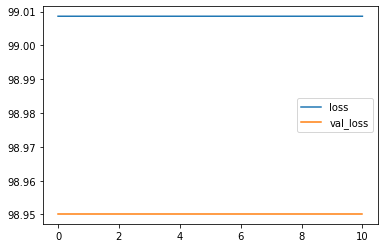

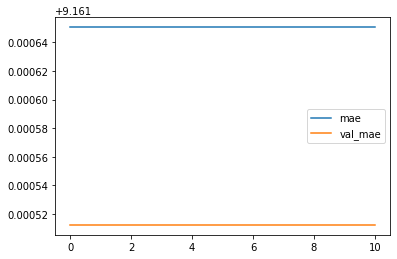

In [18]:
plt.plot(model.history.history["loss"], label="loss");
plt.plot(model.history.history["val_loss"], label="val_loss");
plt.legend();
plt.show();
plt.close();

plt.plot(model.history.history["mae"], label="mae");
plt.plot(model.history.history["val_mae"], label="val_mae");
plt.legend();

## [Use Transfer Learning](https://www.analyticsvidhya.com/blog/2020/03/pretrained-word-embeddings-nlp/)

In [19]:
# load the whole embedding into memory
embeddings_index = dict()

with open("glove/glove.6B.300d.txt") as f:

    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [20]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((size_of_vocabulary, 300))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [21]:
model=Sequential()

#embedding layer
model.add(Embedding(size_of_vocabulary,
                    300,
                    weights=[embedding_matrix],
                    input_length=max_length,
                    trainable=False)) 

#lstm layer
model.add(LSTM(128,return_sequences=True,dropout=0.2))

#Global Maxpooling
model.add(GlobalMaxPooling1D())

#Dense Layer
model.add(Dense(64,activation='relu')) 
model.add(Dense(1,activation='relu')) 

model.compile(optimizer="RMSprop", loss='mean_squared_error', metrics=["mae"]) 

#Print summary of model
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 975, 300)          13567500  
_________________________________________________________________
lstm_2 (LSTM)                (None, 975, 128)          219648    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 13,795,469
Trainable params: 227,969
Non-trainable params: 13,567,500
_________________________________________________________________
None


In [ ]:
history = model.fit(np.array(x_tr_seq),
                    np.array(y_tr),
                    batch_size=128,
                    epochs=1000,
                    validation_data=(np.array(x_val_seq),np.array(y_val)),
                    verbose=1,
                    callbacks=callbacks)

Train on 4652 samples, validate on 1164 samples
Epoch 1/1000


In [ ]:
#evaluation 
_, val_mae = model.evaluate(x_val_seq, y_val)

print("The val_mae is %.3f." % val_mae)

In [ ]:
plt.plot(model.history.history["loss"], label="loss");
plt.plot(model.history.history["val_loss"], label="val_loss");
plt.legend();
plt.show();
plt.close();

plt.plot(model.history.history["mae"], label="mae");
plt.plot(model.history.history["val_mae"], label="val_mae");
plt.legend();